# Tutorial 3: Adaptive Measurements

In this tutorial, we explore the adaptive functionality of the MeasurementControl. With this mode, instead of predefining a grid of values to sweep through, we provide an optimization function and an initial state to the MC. The MC will then use this function to build the sweep. We import our usual modules and setup an MC with visualization: 

In [1]:
from quantify.measurement.control import MeasurementControl
import quantify.visualization.pyqt_plotmon as pqm

In [2]:
MC = MeasurementControl('MC')
plotmon = pqm.PlotMonitor_pyqt('plotmon_MC')
MC.instr_plotmon(plotmon.name)

## Finding a minimum
We will create a mock Instrument our MC will interact with. In this case, it is a simple parabola centred at the origin.

In [3]:
from qcodes.instrument.base import Instrument
from qcodes import ManualParameter, Parameter
from qcodes.utils import validators as vals
import time
import numpy as np

x = ManualParameter('x', unit='m', label='X')
y = ManualParameter('y', unit='m', label='Y')
noise = ManualParameter('noise', unit='V', label='white noise amplitude')

def parabola_model():
    time.sleep(0.01)  # for display purposes, just so we can watch the graph update
    return x() ** 2 + y() ** 2 + noise() * np.random.rand(1)

parabola = Parameter('parabola', unit='V', label='Parabola', get_cmd=parabola_model)

Next, we will use the `optimize` package from `scipy` to provide our adaptive function. You can of course implement your own functions for this purpose, but for brevity we will use something standard and easily available.

In [4]:
from scipy import optimize

Then, we set our Settables and Gettables and usual, and define a new dictionary `af_pars`. The only required key in this object is "adaptive_function", the value of which being the adaptive function to use. The remaining fields in this dictionary are the arguments to the adaptive function itself. We also add some noise into the parabola to stress our adaptive function.

**As such, it is highly recommended to thoroughly read the documentation around the adaptive function you are using.**

We will use the `optimize.minimize` function (note this is passed by reference), which requires an initial state named "x0" and an algorithm to use named "method". In this case, we are starting at (-50, -50) and hope to minimize these values relative to our parabola function. Of course, this parabola has it's global minimum at the origin, thus these values will tend towards 0 as our algorithm progresses.

In [5]:
MC.settables([x, y])
af_pars = {
    "adaptive_function": optimize.minimize,
    "x0": [-50, -50],
    "method": "Nelder-Mead"
}
noise(0.5)
MC.gettables(parabola)
dset = MC.run_adaptive('nelder_mead', af_pars)

 Running adaptively
 Running adaptively

/home/cattryde/PycharmProjects/quantify-core/venv/lib/python3.8/site-packages/qcodes/plots/pyqtgraph.py:410: UserWarning: nonlinear setpoint array passed to pyqtgraph. ignoring, using default scaling.
  warnings.warn('nonlinear setpoint array passed to pyqtgraph. '


 Running adaptively

/home/cattryde/PycharmProjects/quantify-core/venv/lib/python3.8/site-packages/qcodes/plots/pyqtgraph.py:410: UserWarning: nonlinear setpoint array passed to pyqtgraph. ignoring, using default scaling.
  warnings.warn('nonlinear setpoint array passed to pyqtgraph. '


 Running adaptively

/home/cattryde/PycharmProjects/quantify-core/venv/lib/python3.8/site-packages/qcodes/plots/pyqtgraph.py:410: UserWarning: nonlinear setpoint array passed to pyqtgraph. ignoring, using default scaling.
  warnings.warn('nonlinear setpoint array passed to pyqtgraph. '


 Running adaptively

/home/cattryde/PycharmProjects/quantify-core/venv/lib/python3.8/site-packages/qcodes/plots/pyqtgraph.py:410: UserWarning: nonlinear setpoint array passed to pyqtgraph. ignoring, using default scaling.
  warnings.warn('nonlinear setpoint array passed to pyqtgraph. '


 Running adaptively

/home/cattryde/PycharmProjects/quantify-core/venv/lib/python3.8/site-packages/qcodes/plots/pyqtgraph.py:410: UserWarning: nonlinear setpoint array passed to pyqtgraph. ignoring, using default scaling.
  warnings.warn('nonlinear setpoint array passed to pyqtgraph. '


 Running adaptively

/home/cattryde/PycharmProjects/quantify-core/quantify/visualization/plot_interpolation.py:22: RuntimeWarning: invalid value encountered in true_divide
  return (points - xy_mean) / xy_scale


ValueError: Points cannot contain NaN

In [6]:
dset

<xarray.Dataset>
Dimensions:  (dim_0: 512)
Dimensions without coordinates: dim_0
Data variables:
    x0       (dim_0) float64 -50.0 -52.5 -50.0 -47.5 ... 0.336 0.336 0.336 0.336
    x1       (dim_0) float64 -50.0 -50.0 -52.5 -52.5 ... -0.0643 -0.0643 -0.0643
    y0       (dim_0) float64 5e+03 5.257e+03 5.257e+03 ... 0.5194 0.2927 0.493
Attributes:
    tuid:     20200813-184014-695-0e5843
    name:     nelder_mead
    2D-grid:  False

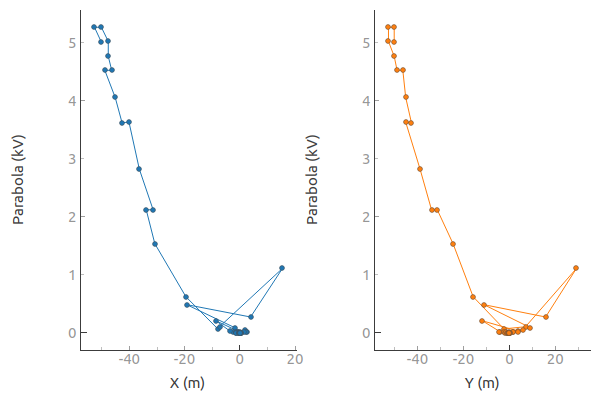

In [7]:
plotmon.main_QtPlot

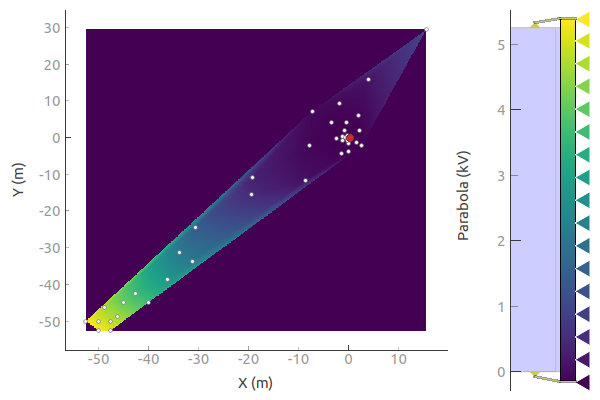

In [8]:
plotmon.secondary_QtPlot

We can see from the graphs that our xn values in the dataset snake towards 0 as expected. Success!

## Adaptive Sampling
Quantify is designed to be modular and the adaptive functions support is no different. To this end, the MC has first class support for the `adaptive` package. Let's see what the same experiment looks like with this module. Note the fields of the `af_pars` dictionary have changed to be compatible with the different adaptive function we are using.

As a practical example, let's revisit a Resonator Spectroscopy experiment. This time we only know our device has a resonance in 6GHz-7GHz range. We really don't want to sweep through a million points, so instead let's use an adaptive sampler to quickly locate our peak.

In [18]:
freq = ManualParameter(name='frequency', unit='Hz', label='Frequency')
amp = ManualParameter(name='amp', unit='V', label='Amplitude')
fwhm = 3e6
resonance_freq = 6.6e9

def lorenz():
    time.sleep(0.5)
    return 1-(amp() * ((fwhm / 2.) ** 2) / ((freq() - resonance_freq) ** 2 + (fwhm / 2.) ** 2))

resonance = Parameter('resonance', unit='V', label='Amplitude', get_cmd=lorenz)

In [19]:
import adaptive

amp(1)
MC.settables([freq])
af_pars = {
    "adaptive_function": adaptive.learner.Learner1D,
    "goal": lambda l: l.npoints > 50,
    "bounds": (6.0e9, 7.0e9),
}
MC.gettables(resonance)
dset = MC.run_adaptive('adaptive sample', af_pars)

 Running adaptively

In [20]:
dset

<xarray.Dataset>
Dimensions:  (dim_0: 51)
Dimensions without coordinates: dim_0
Data variables:
    x0       (dim_0) float64 6.3e+09 6.7e+09 6.5e+09 ... 6.599e+09 6.601e+09
    y0       (dim_0) float64 1.0 0.9998 0.9998 0.9999 ... 0.8715 0.2556 0.2556
Attributes:
    tuid:     20200813-184142-674-028a63
    name:     adaptive sample
    2D-grid:  False

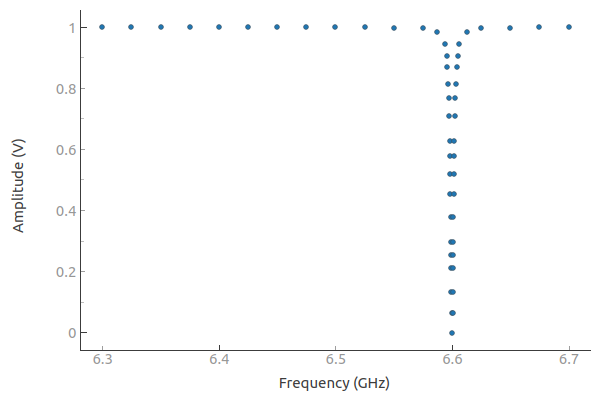

In [21]:
plotmon.main_QtPlot

## FAQ
### Can I return multi-dimensional data from a Gettable in Adaptive Mode?
Yes, but only first dimension (y0) will be considered by the adaptive function; the remaining dimensions will merely be
saved to the dataset.